# Figures for the paper

Idea is not to get 100% in any of these categories, just show the possiibilites with a single model. 

1. Comparing to JET PDB 
    - MTANH fit for pedestal parameters 
    - Compare fit results to that in JET PDB 
    - Should over/under estimate
2. Behaviour in variations of machine parameters
    - Linear in $I_P$
    - $P_{NBI}$ Small effects 
    - See Frassinetti 2020 for more details on waht to expect
3. Comparison of similar pulses
    - Predictions on MPs and Other 
    - Interpolation? 
    - Latent space location ?
4. Error bars
    - Sample repeatedly for a given MP and see in Data space the variation, this is the errors in the estimate. 

Things to keep in mind: 
- Is what we add to the model useful? This being the physics. 

In [229]:
import pickle 
import numpy as np
import pandas as pd
import pathlib 
import os, sys
import torch 
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
from torch.nn import functional as F
from scipy.optimize import curve_fit
from IPython.display import display, HTML
from moxie.models.DIVA_ak_2 import DIVAMODEL
from moxie.data.profile_lightning_module import PLDATAMODULE_AK
from moxie.experiments.DIVA_EXP_AK_1 import EXAMPLE_DIVA_EXP_AK
from moxie.data.utils_ import load_data, standardize, de_standardize, normalize_profiles
# from moxie.models.utils_ import conditional_inference_simple_mean
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
%matplotlib widget

In [28]:
# Load data 
train_data, val_data, test_data = load_data(dataset_choice='SANDBOX_NO_VARIATIONS', file_loc='/home/kitadam/ENR_Sven/moxie/data/processed/pedestal_profiles_ML_READY_ak_19042022.pickle')
(train_X, train_y, train_mask, train_radii, train_real_space_radii, train_ids), (val_X, val_y, val_mask, val_radii, val_real_space_radii, val_ids), (test_X, test_y, test_mask, test_radii, test_real_space_radii, test_ids) = train_data, val_data, test_data

machine_param_order = ['Q95', 'RGEO', 'CR0', 'VOLM', 'TRIU', 'TRIL', 'ELON', 'POHM', 'IPLA', 'BVAC', 'NBI', 'ICRH', 'ELER']
JET_PDB = pd.read_csv('/home/kitadam/ENR_Sven/moxie/data/processed/jet-pedestal-database.csv')
PULSE_DF_SANDBOX = JET_PDB[(JET_PDB['FLAG:HRTSdatavalidated'] > 0) & (JET_PDB['shot'] > 80000) & (JET_PDB['Atomicnumberofseededimpurity'].isin([0, 7])) & (JET_PDB['FLAG:DEUTERIUM'] == 1.0) & (JET_PDB['FLAG:Kicks'] == 0.0) & (JET_PDB['FLAG:RMP'] == 0.0) & (JET_PDB['FLAG:pellets'] == 0.0)]
relevant_columns = ['shot', 'nepedheight10^19(m^-3)','Tepedheight(keV)', 'B(T)','Ip(MA)', 'q95',  'R(m)', 'a(m)','gasflowrateofmainspecies10^22(e/s)',  'P_TOT=PNBI+Pohm+PICRH-Pshi(MW)', 'P_ICRH(MW)', 'P_NBI(MW)','plasmavolume(m^3)', 'averagetriangularity', 'divertorconfiguration', 'FLAG:Seeding', 'FLAG:Kicks',
 'FLAG:RMP',
 'FLAG:pellets',]
FLAGS = [x for x in JET_PDB.columns.to_list() if 'FLAG' in x]

In [296]:
# Load model 
model_hyperparams_physics = {'in_ch': 2, 'out_length':19,
                    'mach_latent_dim': 10, 'stoch_latent_dim': 3,
                    'beta_stoch': 1.0, 'beta_mach_unsup':  0.001,'beta_mach_sup':  0.0,
                    'alpha_mach': 1.0, 'alpha_prof': 20.0,  # 212, 306, 26, 295, 263, 336] 	[485, 499, 352, 432]
                    'start_sup_time': 1000,
                    'physics': False, 'gamma_stored_energy': 1.0, 'gamma_bpol': 1.0, 'gamma_beta': 1.0, 
                    'mp_hdims_aux': [256, 128, 64], 'mp_hdims_cond':[256, 128, 64], # 'mp_hdims_aux': [263, 469, 284], 'mp_hdims_cond':[20, 136, 54, 205, 154, 408], # 'mp_hdims_cond': [397, 369, 29, 113, 284], 'mp_hdims_aux': [122, 398, 463, 354, 399], 
                    'hidden_dims': [2, 4], 'loss_type': 'semi-supervised',}
model_physics = DIVAMODEL(**model_hyperparams_physics)
model_name_physics = 'modelstatedict_SCHEDULER_SECULAR_10MD_3SD_0BMUN_0.0BMSUP_1.1BS_1AM_500AP_50EP'
# model_name = 'modelstatedict_SCHEDULER_PHYSICS_10MD_3SD_0BMUN_0.0BMSUP_2.403BS_11AM_356AP_100EP_0.6GAMMA' # prior [485, 499, 352, 432], cond [212, 306, 26, 295, 263, 336], LD 10, 
state_dict = torch.load('../EPED_oder_uns/model_results/{}.pth'.format(model_name_physics))
model_physics.load_state_dict(state_dict['model'])

# Convert things to tensors 
norms_MP, norms_D, norms_T = state_dict['MP_norms'], state_dict['D_norms'], state_dict['T_norms']
MP_norm, MP_var = norms_MP
D_norm, D_var = norms_D
T_norm, T_var = norms_T


# Training Tensors 

train_mp_tensors = torch.tensor(train_y).float()
val_mp_tensors = torch.tensor(val_y).float()
test_mp_tensors = torch.tensor(test_y).float()
all_mp_tensors = torch.vstack((train_mp_tensors, val_mp_tensors, test_mp_tensors))


train_mp_normalized = standardize(train_mp_tensors, MP_norm, MP_var)
val_mp_normalized = standardize(val_mp_tensors, MP_norm, MP_var)
test_mp_normalized = standardize(test_mp_tensors, MP_norm, MP_var)

train_profiles = torch.tensor(train_X).float()
val_profiles = torch.tensor(val_X).float()
test_profiles = torch.tensor(test_X).float()
all_profiles = torch.vstack((train_profiles, val_profiles, test_profiles))

train_profiles_normalized = torch.clone(train_profiles).float()
train_profiles_normalized = normalize_profiles(train_profiles, T_norm, T_var, D_norm, D_var)

val_profiles_normalized = torch.clone(val_profiles).float()
val_profiles_normalized = normalize_profiles(val_profiles_normalized, T_norm, T_var, D_norm, D_var)

test_profiles_normalized = torch.clone(test_profiles).float()
test_profiles_normalized = normalize_profiles(test_profiles_normalized, T_norm, T_var, D_norm, D_var)

# Ordering and pulse ids

train_pulse_order = [int(x.split('/')[0]) for x in train_ids]
train_pulses = list(set(train_pulse_order))
train_pulse_idxs = [[index for index in range(len(train_pulse_order)) if train_pulse_order[index] == pulse] for pulse in train_pulses]

val_pulse_order = [int(x.split('/')[0]) for x in val_ids]
val_pulses = list(set(val_pulse_order))
val_pulse_idxs = [[index for index in range(len(val_pulse_order)) if val_pulse_order[index] == pulse] for pulse in val_pulses]

test_pulse_order = [int(x.split('/')[0]) for x in test_ids]
test_pulses = list(set(test_pulse_order))
test_pulse_idxs = [[index for index in range(len(test_pulse_order)) if test_pulse_order[index] == pulse] for pulse in test_pulses]

all_pulse_order = train_pulse_order + val_pulse_order + test_pulse_order 
all_pulses = list(set(all_pulse_order))
all_pulse_idxs = [[index for index in range(len(all_pulse_order)) if all_pulse_order[index] == pulse] for pulse in all_pulses]


# 1) Compare with JET PDB 

In [204]:
def mtanh(r_vals, h1, h0, p, w, s):
    x = (p-r_vals) / (w/2.0)
    return (h1/2.0 - h0/2.0)*((((1+s*x)*np.exp(x)) - np.exp(-x)) / (np.exp(x) + np.exp(-x)) + 1) + h0
    
def calculate_ped_params_from_fit(PROFILES, profiles_predictions, pedestal_database): 
    """
    A very shitty function that returns the pedestal fit parameters for a single pulse (multiple time slices). 
    If the fit fails to be found, it returns an nan for all fit params in conditional or experimental for the given time slice it failed on
    
    Parameters
    ----------
    
    PROFILES: profiles_real, radii, masks, ids, mps, real_radii
    
    profiles_predictions: the conditional generated profiles, with obviously same shape as profiles_real
    
    Returns
    ----------
    
    cond_pred_fit_params, real_fit_params, (ne_jetpbd, te_jetpdb, pe_jetpdb): np.array((3, 5, len(profiles))), np.array((3, 5, len(profiles))), (np.array(5), np.array(5), np.array(5))
        i.) Conditional fit params for all time slices in pulse, ii) experrimetnal fit params for all slices in pulse iii) tuple with the 
        fit param arrays look like this: 
        [ ne[height (10^-19 m^-3), offset(-), position(m), width(m), slope(-)], 
          te[height (keV), offset(-), position(m), width(m), slope(-)], 
          pe[height (kPa), offset (-), position(m), width(m), slope(-)]
        ]

    The condiitonal fit params for pe height come out a factor of 2 less for some reason, 
    """
    profiles_real, radii, masks, ids, mps, real_radii = PROFILES 
    profiles_con = profiles_predictions
    # grab parameters from Jet PDB 
    JPDB_pulse = pedestal_database[pedestal_database['shot'] == ids]
    
    # h1, h0, p, w, s
    initial_guesses_ne = np.array([JPDB_pulse['nepedheight10^19(m^-3)'].values[0], 0.0,  JPDB_pulse['nepositionRmid(m)'].values[0],0.01*JPDB_pulse['NepedestalwidthRmid(cm)'].values[0],JPDB_pulse['neinnerslope'].values[0], ])
    initial_guesses_te = np.array([JPDB_pulse['Tepedheight(keV)'].values[0], 0.0,  JPDB_pulse['TepositionRmid(m)'].values[0],0.01*JPDB_pulse['TepedestalwidthRmid(cm)'].values[0],JPDB_pulse['Teinnerslope'].values[0], ])
    initial_guesses_pe = np.array([JPDB_pulse['pepedheight(kPa)'].values[0] / 2.0, 0.0,  JPDB_pulse['pepositionRmid(m)'].values[0],0.01*JPDB_pulse['pepedestalwidthRmid(cm)'].values[0],JPDB_pulse['peinnerslope'].values[0], ])
    
    cond_pred_fit_params, real_fit_params, = np.zeros((3, 5, len(profiles_con))), np.zeros((3, 5, len(profiles_con)))
    mean_cond_fit_params, mean_real_fit_params = np.zeros((3, 5)), np.zeros((3, 5))
    # conditional predictions
    d_profs_con, t_profs_con = profiles_con[:, 0, :], profiles_con[:, 1, :]
    d_profs_real, t_profs_real = profiles_real[:, 0, :], profiles_real[:, 1, :]
    
    mean_d_profs_con, mean_t_profs_con = torch.mean(1e-19*d_profs_con, 0), torch.mean(1e-3*t_profs_con, 0)
    mean_d_profs_real, mean_t_profs_real = torch.mean(1e-19*d_profs_real, 0), torch.mean(1e-3*t_profs_real, 0)
    mean_p_profs_con, mean_p_profs_real = mean_d_profs_con*mean_t_profs_con, mean_d_profs_real*mean_t_profs_real
    
    for n, (d_prof, t_prof, rad, mask, d_prof_real, t_prof_real) in enumerate(zip(d_profs_con, t_profs_con, real_radii, masks, d_profs_real, t_profs_real)):
        xdata = rad[mask]
        
        xdata_fit = np.linspace(3.7, 3.9, 50)
        ydata_d = d_prof[mask]*1e-19
        ydata_t = t_prof[mask] / 1000.0
        
        ydata_d_real = d_prof_real[mask]*1e-19
        ydata_t_real = t_prof_real[mask] / 1000.0

        try: 
            popt_d, pcov_d = curve_fit(mtanh, xdata, ydata_d, p0 = initial_guesses_ne, maxfev = 2000)
            popt_t, pcov_t = curve_fit(mtanh, xdata, ydata_t, p0 = initial_guesses_te, maxfev = 2000)
            popt_p, pcov_p = curve_fit(mtanh, xdata, ydata_t*ydata_d, p0 = initial_guesses_pe, maxfev = 2000)
            
        except RuntimeError as e: 
            popt_d, popt_t, popt_p = [np.nan]*5, [np.nan]*5, [np.nan]*5
            
        try: 
            popt_d_real, pcov_d_real = curve_fit(mtanh, xdata, ydata_d_real, p0 = initial_guesses_ne, maxfev = 2000)
            popt_t_real, pcov_t_real = curve_fit(mtanh, xdata, ydata_t_real, p0 = initial_guesses_te, maxfev = 2000)
            popt_p_real, pcov_p_real = curve_fit(mtanh, xdata, ydata_d_real*ydata_t_real, p0 = initial_guesses_pe, maxfev = 2000)
        
        except RuntimeError as e: 
            popt_d_real, popt_t_real, popt_p_real = [np.nan]*5, [np.nan]*5, [np.nan]*5
        
        cond_pred_fit_params[0, :, n] = popt_d
        cond_pred_fit_params[1, :, n] = popt_t
        cond_pred_fit_params[2, :, n] = popt_p
        
        real_fit_params[0, :, n] = popt_d_real
        real_fit_params[1, :, n] = popt_t_real
        real_fit_params[2, :, n] = popt_p_real
        
    initial_guesses_pe[0] = initial_guesses_pe[0]*2
    return cond_pred_fit_params, real_fit_params, np.vstack((initial_guesses_ne, initial_guesses_te, initial_guesses_pe))

import warnings
from tqdm.notebook import tqdm
def do_all_pulses(pedestal_database, pulse_ids, pulse_profiles, pulse_mask, pulse_mps, pulse_rmid, pulse_psi, pulses, model):
    """
    
    pedestal_database, pulse_rmid, pulse_psi
    
    Parameters
    ----------
    
    pulse_ids:
        is a list of lists, for each pulse, it denotes the locations of all time slices in that pulse 
        To get the list of indexes for the given pulse, access it via pulse_ids[0]
        To get the profiles for a given pulse you can then use: pulse_profiles[pulse_ids[0]]
    pulse_profiles: 
        All tensors for a given data subset (train-val-test)
    pulse_mask: 
        All mask tensors, to be accessed via > 0 
    pulses: int
        The actual pulse number 
    pulse_mps: 
        same as pulse_profiles but for hte machine parameters 
    
    Returns
    -------
    
    cond_pred_means: np.array((3, 5, # Pulses))
        For all pulses, the pedestal parameters from the conditional prior 
        This comes in the same row column format as pefore
        Accessing the ne height is then something like: 
        neped_conditional = cond_pred_means[0, 0, :]
    real_pred_means: np.array((3, 5, # Pulses))
    frass_means: np.array((3, 5, # Pulses))
    
    """
    iterator = tqdm(range(len(pulse_ids)))
    shot_list = pedestal_database['shot'].to_list()
        
    cond_pred_means, real_pred_means, frass_means = np.zeros((3, 5, len(pulse_ids))), np.zeros((3, 5, len(pulse_ids))), np.zeros((3, 5, len(pulse_ids)))
    cond_pred_stds, real_pred_stds = np.zeros((3, 5, len(pulse_ids))), np.zeros((3, 5, len(pulse_ids)))
    # rows: 0: ne, 1: te, 2: pe
    # cols: means: [height (10^-19 m^-3), offset(-), position(m), width(m), slope(-)], 
    # z dim is per pulse 
    
    for k in iterator: 
        iterator.set_postfix_str(str(pulses[k]))
        
        if pulses[k] not in shot_list: 
            # Set to NAN! 
            cond_pred_means[:, :, k], real_pred_means[:, :, k], frass_means[:, :, k] = np.zeros((3,5)) * np.nan, np.zeros((3,5)) * np.nan, np.zeros((3,5)) * np.nan 
            cond_pred_stds[:, :, k], real_pred_stds[:, :, k] = np.zeros((3,5)) * np.nan, np.zeros((3,5)) * np.nan 
            # neped_height_mean[k] = np.nan#  abs(filtered_pred_fit_params[0, :, :].mean(1))[0]
            continue           
        PULSE_sample = pulse_profiles[pulse_ids[k]], pulse_psi[pulse_ids[k]], pulse_mask[pulse_ids[k]] > 0, pulses[k], pulse_mps[pulse_ids[k]], pulse_rmid[pulse_ids[k]]
        PULSE_conditional = conditional_inference_simple_mean(PULSE_sample, model)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            cond_pred_fit_params, real_fit_params, frassineti = calculate_ped_params_from_fit(PULSE_sample, PULSE_conditional, pedestal_database)
            cond_pred_means[:, :, k], real_pred_means[:, :, k], frass_means[:, :, k] = np.mean(cond_pred_fit_params, 2), np.mean(real_fit_params, 2), frassineti
            cond_pred_stds[:, :, k], real_pred_stds[:, :, k] = np.std(cond_pred_fit_params, 2), np.std(real_fit_params, 2)
    return cond_pred_means, real_pred_means, frass_means, cond_pred_stds, real_pred_stds

def plot_ped_params_results(cond_pred_means, real_pred_means, frass_means):  
    params = ['Height', 'Position','Width', 'Slope']
    params_idx = [0, 2, 3, 4]
    lim_dict = {'Height': {'0': (1, 11), '1': (0, 1.3), '2': (0, 13)}, 
                'Position': {'0': (3.785, 3.865), '1': (3.785, 3.85), '2':(3.78, 3.85)}, 
               'Width': {'0': (None, None), '1': (None, None), '2':(None, None)}, 
               'Slope': {'0': (None, None), '1': (0, 0.6), '2':(0, 0.6)}}    
    
    for p, p_idx in zip(params, params_idx): 
        

        fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(13, 5))
        fig.suptitle(p)

        for i in [0, 1, 2]: 
            if p == 'Height' and i == 2: 
                scaling_factor = 2.0 
            else: 
                scaling_factor = 1.0
            axs[i].scatter(frass_means[i, p_idx, :], scaling_factor*cond_pred_means[i, p_idx, :])
            axs[i].plot([min(frass_means[i, p_idx, :]), max(frass_means[i, p_idx, :])],[min(frass_means[i, p_idx, :]), max(frass_means[i, p_idx, :])], 'k--')
            axs[i].set(ylim=lim_dict[p][str(i)], xlim=lim_dict[p][str(i)])   

def plot_all_sets_params_results(train_res, val_res, test_res, errors=False): 
    params = ['Height', 'Position (m)','Width (m)', 'Slope (-)']
    params_idx = [0, 2, 3, 4]
    lim_dict = {'Height': {'0': (1, 11), '1': (0, 1.3), '2': (0, 13)}, 
                'Position (m)': {'0': (3.785, 3.865), '1': (3.785, 3.85), '2':(3.78, 3.85)}, 
               'Width (m)': {'0': (None, None), '1': (None, None), '2':(None, None)}, 
               'Slope (-)': {'0': (None, None), '1': (0, 0.6), '2':(0, 0.6)}}    
    title = ['ne', 'te', 'pe']
    labels = ['Train', 'Valid', 'Test']
    for p, p_idx in zip(params, params_idx): 
        fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(13, 5))
        fig.suptitle(p)
        for n, data_set in enumerate([train_res, val_res, test_res]):
            cond_pred_means, _, frass_means, cond_pred_std, _ = data_set
            for i in [0, 1, 2]: 
                if p == 'Height' and i == 2: 
                    scaling_factor = 2.0 
                else: 
                    scaling_factor = 1.0
                axs[i].scatter(frass_means[i, p_idx, :], scaling_factor*cond_pred_means[i, p_idx, :], label=labels[n])
                if errors: 
                    axs[i].errorbar(frass_means[i, p_idx, :], scaling_factor*cond_pred_means[i, p_idx, :], yerr=cond_pred_std[i, p_idx, :], alpha=0.3, color='grey', fmt='none')
                if n == 0: 
                    axs[i].plot([min(frass_means[i, p_idx, :]), max(frass_means[i, p_idx, :])],[min(frass_means[i, p_idx, :]), max(frass_means[i, p_idx, :])], 'k--')
                    axs[i].set(ylim=lim_dict[p][str(i)], xlim=lim_dict[p][str(i)], title=title[i])   
            axs[0].legend()


train_res = do_all_pulses(JET_PDB, train_pulse_idxs, train_profiles, train_mask, train_mp_tensors, train_real_space_radii, train_radii, train_pulses, model=model_physics)
val_res = do_all_pulses(JET_PDB, val_pulse_idxs, val_profiles, val_mask, val_mp_tensors, val_real_space_radii, val_radii, val_pulses, model=model_physics)
test_res = do_all_pulses(JET_PDB, test_pulse_idxs, test_profiles, test_mask, test_mp_tensors, test_real_space_radii, test_radii, test_pulses, model=model_physics)



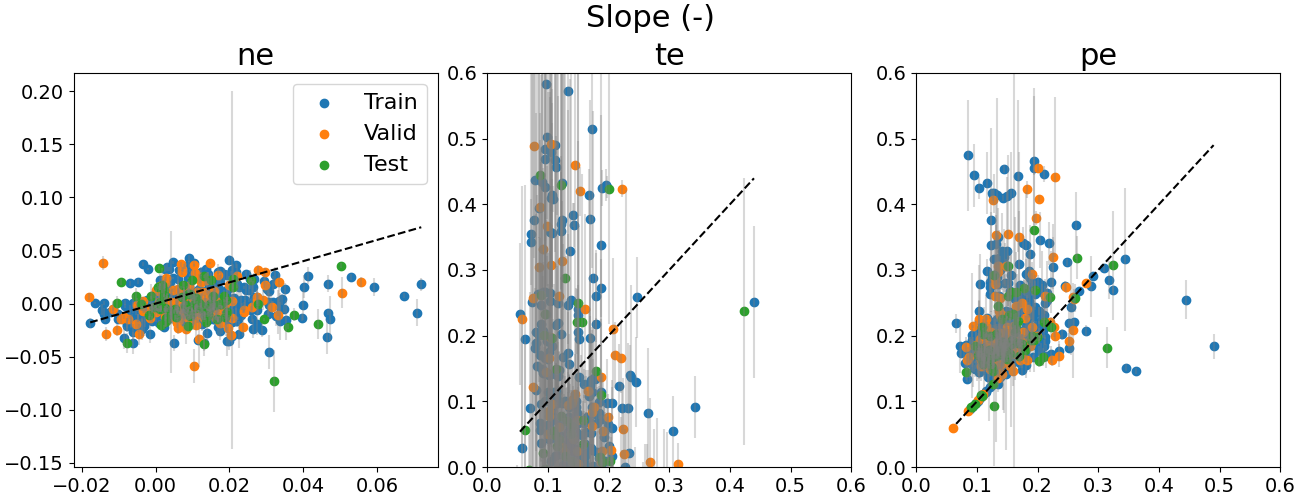

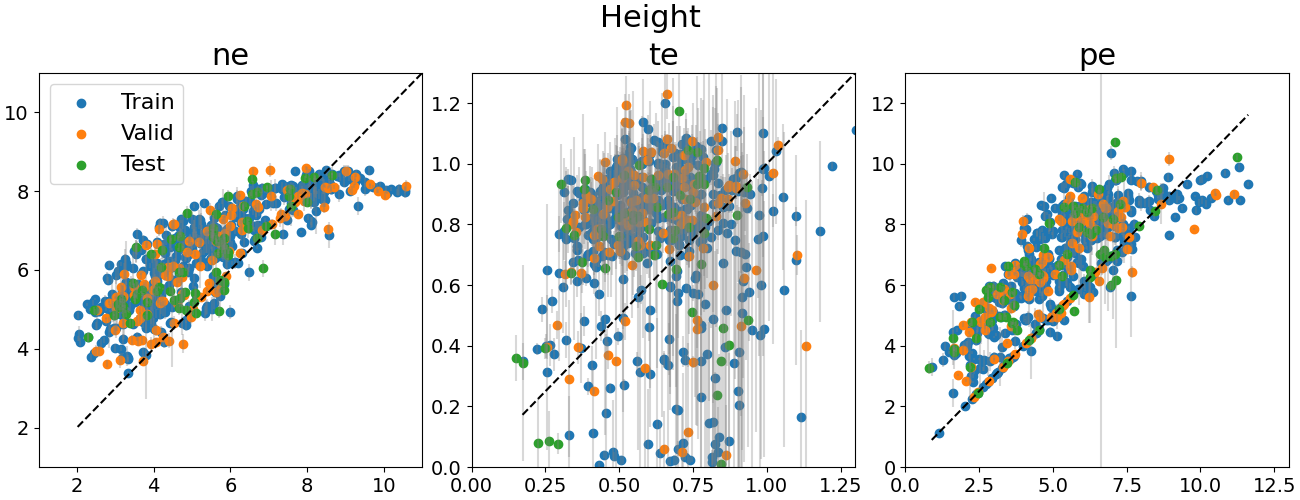

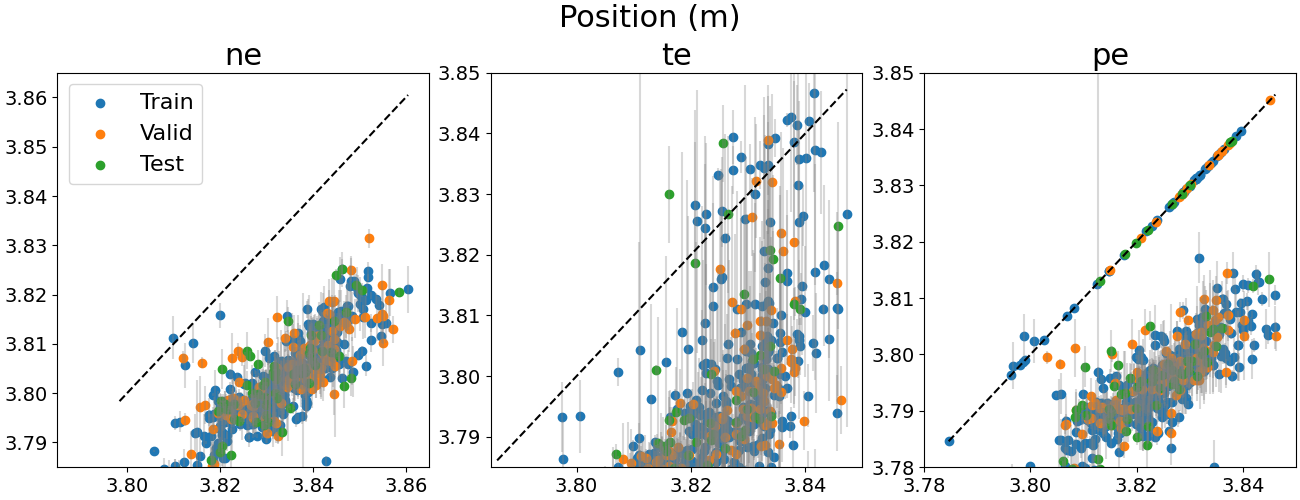

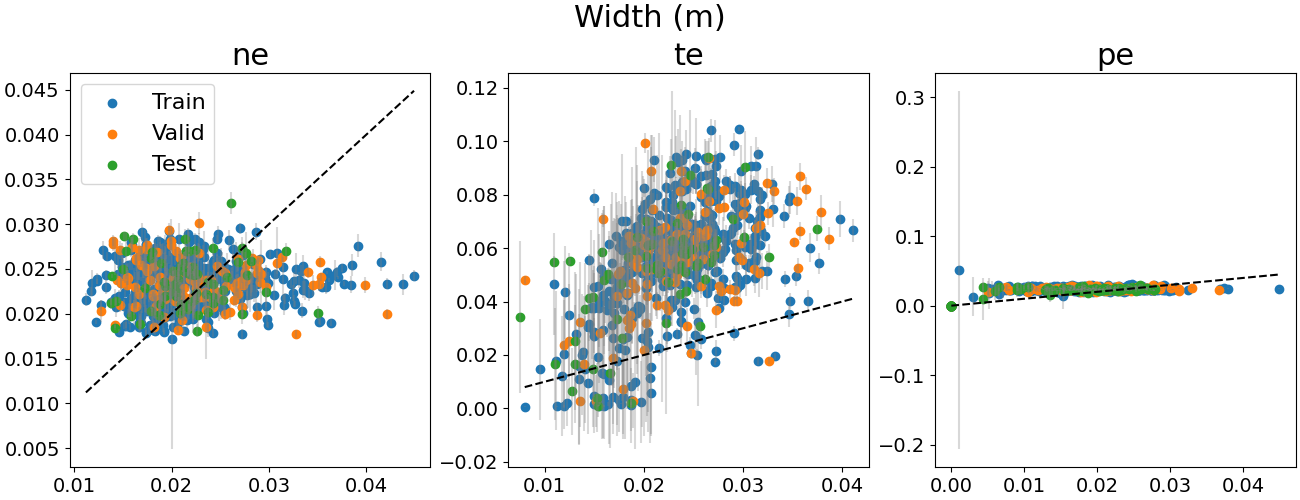

In [205]:
plt.close('all')
cond_pred_means_train, real_pred_means_train, frass_means_train, _, _= train_res
cond_pred_means_val, real_pred_means_val, frass_means_val, _, _ = val_res
cond_pred_means_test, real_pred_means_test, frass_means_test, _, _ = test_res
plot_all_sets_params_results(train_res, val_res, test_res, errors=True)
# plot_ped_params_results(cond_pred_means_val, real_pred_means_val, frass_means_val)
plt.show()

2. Behaviour in variations of machine parameters
    - Linear in $I_P$
    - $P_{NBI}$ Small effects 
    - See Frassinetti 2020 for more details on waht to expect


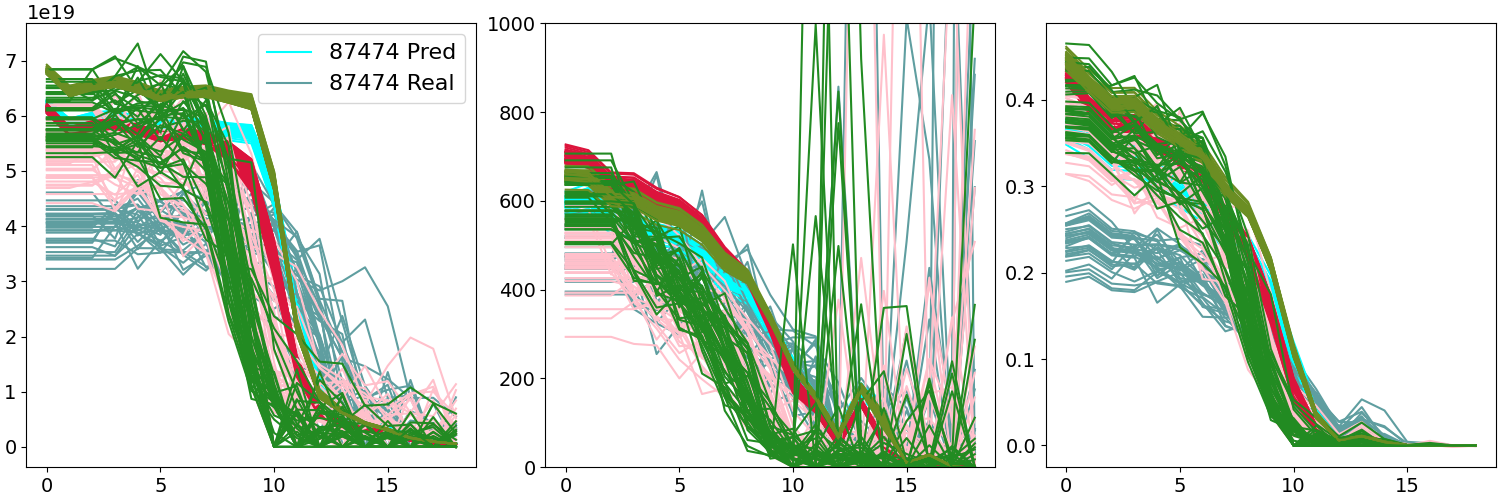

"\nmp_cols_jetpbd = ['B(T)','Ip(MA)', 'q95',  'R(m)', 'a(m)','gasflowrateofmainspecies10^22(e/s)',  'P_TOT=PNBI+Pohm+PICRH-Pshi(MW)', 'P_ICRH(MW)', 'P_NBI(MW)','plasmavolume(m^3)', 'averagetriangularity']\ncurrent_subset = PULSE_DF_SANDBOX[(PULSE_DF_SANDBOX['P_TOT=PNBI+Pohm+PICRH-Pshi(MW)'] < 13) & (PULSE_DF_SANDBOX['P_TOT=PNBI+Pohm+PICRH-Pshi(MW)'] > 10) & (PULSE_DF_SANDBOX['gasflowrateofmainspecies10^22(e/s)'] > 2)& (PULSE_DF_SANDBOX['gasflowrateofmainspecies10^22(e/s)'] < 3)& (PULSE_DF_SANDBOX['q95'] > 2.7) & (PULSE_DF_SANDBOX['q95'] < 3.5)& (PULSE_DF_SANDBOX['averagetriangularity'] < 0.27)] # & (PULSE_DF_SANDBOX['divertorconfiguration'] == 'C/C')\n\nminima = min(current_subset['Ip(MA)'])\nmaxima = max(current_subset['Ip(MA)'])\n\n\n\nnorm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)\nmapper = cm.ScalarMappable(norm=norm, cmap=cm.Spectral)\n\nplt.close('all')\nfig = plt.figure()\nplt.scatter(current_subset['nepedheight10^19(m^-3)'], current_subset['Tepedheight(

In [344]:
# Select a pulse, then vary the current
# This is probably a bad idea, as current will change many things, like q_cycl

# Select a few pulses that slowly increase in current and show the prediction between them. 
# Potential for current shots are 87474 (train), 92234 (test), 92439 (train) -> Can show if it picks up in the middle! 
idx_low_train = train_pulse_idxs[train_pulses.index(87474)]
idx_high_train = train_pulse_idxs[train_pulses.index(92439)]
idx_mid_test = test_pulse_idxs[test_pulses.index(92234)]

train_profiles_for_plot, train_mps_for_plot = train_profiles[idx_low_train + idx_high_train], train_mp_tensors[idx_low_train + idx_high_train]

idx_low = all_pulse_idxs[all_pulses.index(87474)]
idx_high = all_pulse_idxs[all_pulses.index(92439)]
idx_mid = all_pulse_idxs[all_pulses.index(92234)]

idxs_dict = {'low': {'idxs': idx_low, 'colors': ('aqua', 'cadetblue'), 'label': str(87474)}, 
             'med': {'idxs': idx_mid, 'colors': ('crimson', 'pink'), 'label': str(92234)}, 
             'high': {'idxs': idx_high, 'colors': ('olivedrab', 'forestgreen'), 'label': str(92439)}}

plt.close('all')
fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(15, 5))
for name, idxs in idxs_dict.items(): 
    profiles_for_plot, mps_for_plot = all_profiles[idxs['idxs']], all_mp_tensors[idxs['idxs']]
    PULSE_sample = profiles_for_plot, None, None, None, mps_for_plot, None # profiles, psi, mask > 0, pulses, pulse_mps, rmid
    PULSE_conditional = conditional_inference_simple_mean(PULSE_sample, model_physics)
    d_profs_real, t_profs_real = profiles_for_plot[:, 0, :], profiles_for_plot[:, 1, :]
    d_profs_con, t_profs_con = PULSE_conditional[:, 0, :], PULSE_conditional[:, 1, :]
    
    
    for n, (d_prof, t_prof, d_prof_real, t_prof_real) in enumerate(zip(d_profs_con, t_profs_con, d_profs_real, t_profs_real)):
        axs[0].plot(d_prof, color=idxs['colors'][0], label=idxs['label'] + ' Pred')
        axs[0].plot(d_prof_real, color=idxs['colors'][1], label=idxs['label'] + ' Real')

        axs[1].plot(t_prof, color=idxs['colors'][0], label=idxs['label'] + ' Pred')
        axs[1].plot(t_prof_real, color=idxs['colors'][1], label=idxs['label'] + ' Pred')

        axs[2].plot(1e-23*d_prof*t_prof, color=idxs['colors'][0], label=idxs['label'] + ' Pred')
        axs[2].plot(1e-23*d_prof_real*t_prof, color=idxs['colors'][1], label=idxs['label'] + ' Pred')
        
        if n == 0 and name == 'low': 
            axs[0].legend()
    
    
    axs[1].set_ylim(0, 1000)
plt.show()    


# PULSE_sample = train_profiles[idx_los_train + idx_high_train], pulse_psi[pulse_ids[k]], pulse_mask[pulse_ids[k]] > 0, pulses[k], pulse_mps[pulse_ids[k]], pulse_rmid[pulse_ids[k]]

# take the test profiles 
# propogate them both through conditional things 
# show profiles comparison 




"""
mp_cols_jetpbd = ['B(T)','Ip(MA)', 'q95',  'R(m)', 'a(m)','gasflowrateofmainspecies10^22(e/s)',  'P_TOT=PNBI+Pohm+PICRH-Pshi(MW)', 'P_ICRH(MW)', 'P_NBI(MW)','plasmavolume(m^3)', 'averagetriangularity']
current_subset = PULSE_DF_SANDBOX[(PULSE_DF_SANDBOX['P_TOT=PNBI+Pohm+PICRH-Pshi(MW)'] < 13) & (PULSE_DF_SANDBOX['P_TOT=PNBI+Pohm+PICRH-Pshi(MW)'] > 10) & (PULSE_DF_SANDBOX['gasflowrateofmainspecies10^22(e/s)'] > 2)& (PULSE_DF_SANDBOX['gasflowrateofmainspecies10^22(e/s)'] < 3)& (PULSE_DF_SANDBOX['q95'] > 2.7) & (PULSE_DF_SANDBOX['q95'] < 3.5)& (PULSE_DF_SANDBOX['averagetriangularity'] < 0.27)] # & (PULSE_DF_SANDBOX['divertorconfiguration'] == 'C/C')

minima = min(current_subset['Ip(MA)'])
maxima = max(current_subset['Ip(MA)'])



norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Spectral)

plt.close('all')
fig = plt.figure()
plt.scatter(current_subset['nepedheight10^19(m^-3)'], current_subset['Tepedheight(keV)'], color=mapper.to_rgba(current_subset['Ip(MA)']))
fig.colorbar(mapper)
plt.xlim(2, 10)
plt.ylim(0, 1)
plt.show()
display(HTML(current_subset[['shot', 'nepedheight10^19(m^-3)'] + mp_cols_jetpbd].to_html()))
# PULSE_DF_SANDBOX['P_TOT=PNBI+Pohm+PICRH-Pshi(MW)']
"""


In [276]:
92439 in train_pulses

True

In [190]:
PULSE_DF_SANDBOX[['nepedheight10^19(m^-3)', 'Ip(MA)']].sort_values('Ip(MA)', ascending=True).tail(15)

,nepedheight10^19(m^-3),Ip(MA)
1462,6.032837,3.173964
1463,5.515625,3.180193
1886,9.712277,3.215923
893,7.535075,3.234806
1392,5.532164,3.468777
1389,6.002741,3.471150
1390,5.537192,3.471603
1391,5.455696,3.473238
894,8.018541,3.478739
1393,5.691937,3.479923
